In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\figure.py:2533: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if not np.isfinite(figsize).all() or (np.array(figsize) < 0).any():


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

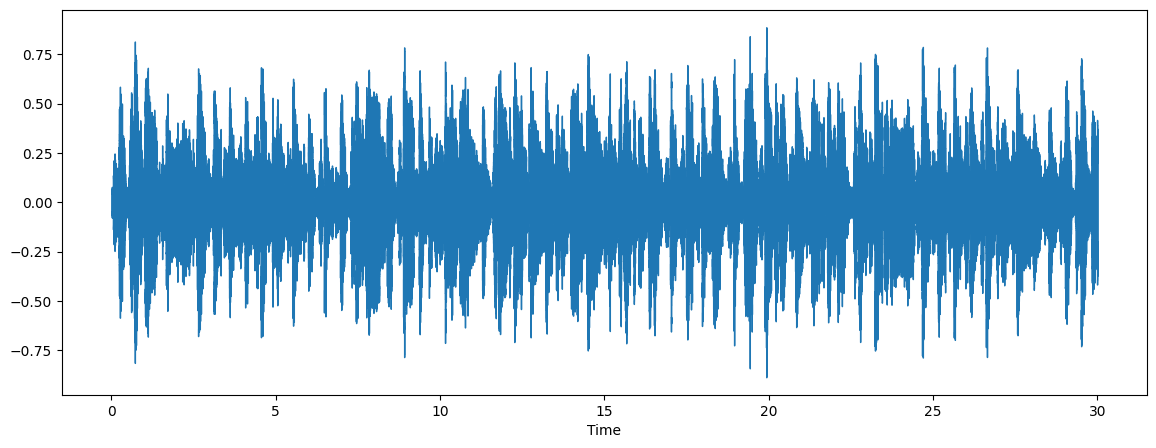

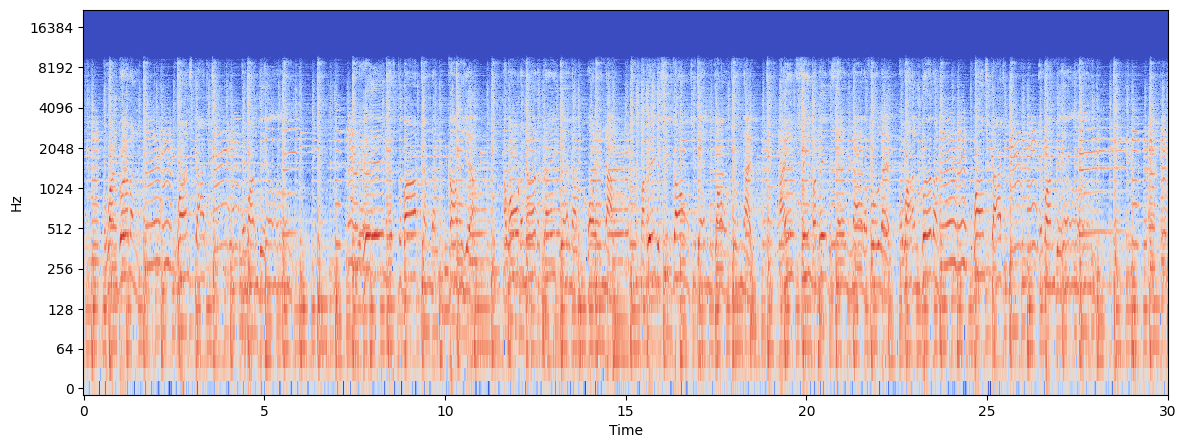

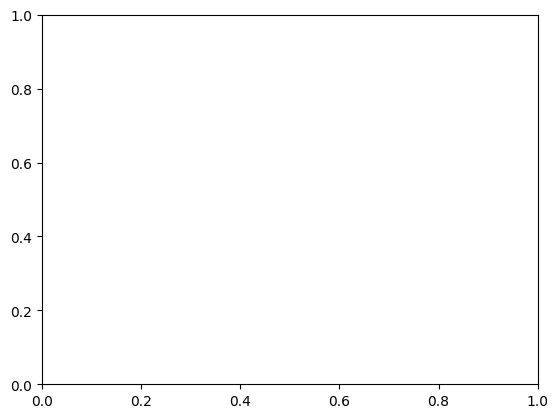

<Figure size 640x480 with 0 Axes>

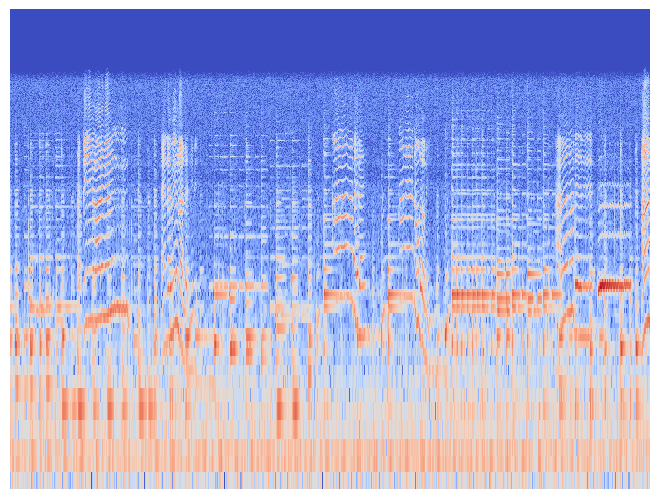

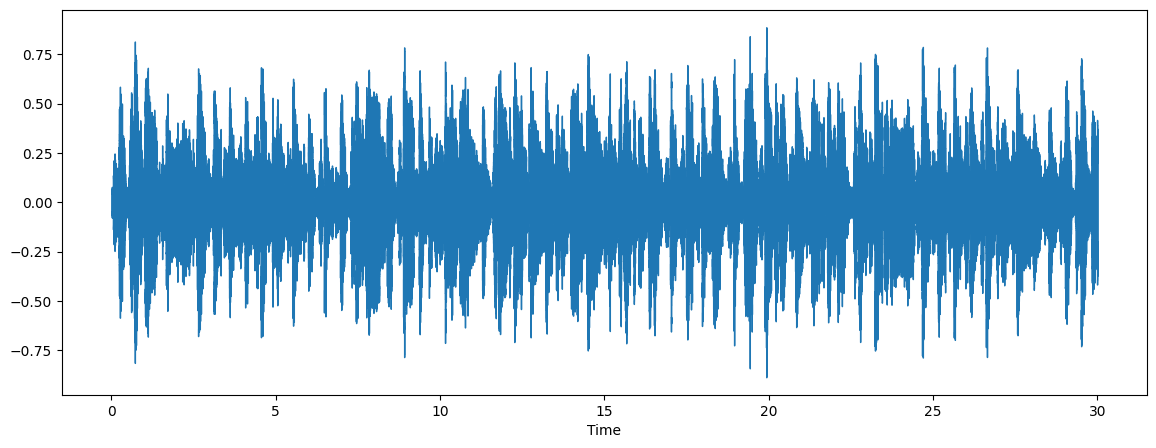

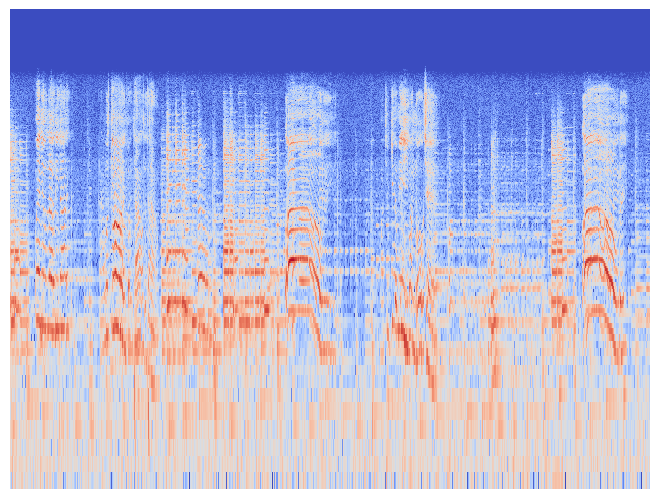

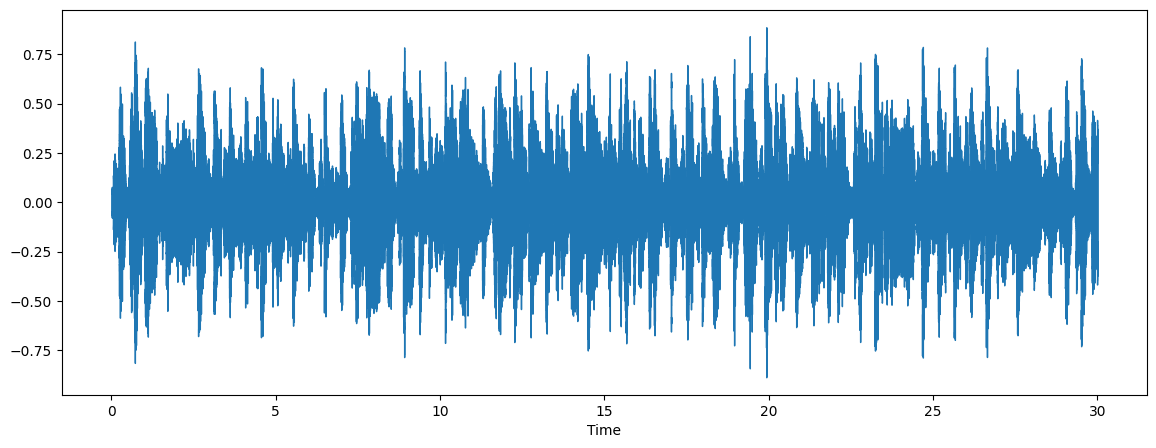

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [10]:
def create_and_save_spectogram(file_path, save_path, display_plots):
    x, sr, Xdb = calculate_spectogram_data(file_path)
    create_spectogram_plot_and_save(Xdb, sr, save_path)
    if display_plots:
        display_diagrams(x, sr, Xdb)


def calculate_spectogram_data(file_path):
    x, sr = librosa.load(file_path, sr=44100)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    return x, sr, Xdb


def create_spectogram_plot_and_save(Xdb, sr, save_path):
    figure = plt.figure(frameon=False)
    ax = plt.Axes(figure, [0., 0., 1., 1.])
    ax.set_axis_off()
    figure.add_axes(ax)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    plt.savefig(save_path)
    plt.close(figure)


def display_diagrams(x, sr, Xdb):
    display_waveform(x, sr)
    display_spectogram(Xdb, sr)


def display_waveform(x, sr):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)


def display_spectogram(Xdb, sr):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


audio_files_root_dir = 'Data/genres_original/'
display_plots = True

for subdir, dirs, files in os.walk(audio_files_root_dir):
    for file in files:
        file_info = file.split('.')
        create_and_save_spectogram(os.path.join(subdir, file), f'Data/spectograms/{file_info[0]}/{file_info[0]}.{file_info[1]}.png', display_plots)
        display_plots = False